## ASSIGNMENT 4 - INTERPRETABILITY (SHAPLEY)

### IMPORTING PACKAGES

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import shap
import warnings


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### DATA PREPROCESSING

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [4]:
df_drop = df.drop(columns=['longitude', 'latitude', 'ocean_proximity'])

In [5]:
X = df_drop.drop(columns='median_house_value')
y = df_drop['median_house_value']/100000

In [6]:
# Data Cleaning: Check for NaNs and fill or remove them if necessary
if X.isnull().values.any(): 
    X = X.fillna(X.mean())  # Replace NaNs with the mean of the column
if y.isnull().values.any(): 
    y = y.fillna(y.mean())  # Replace NaNs in the target variable

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### DATA SAMPLING

In [8]:
X_train_10000 = X_train.sample(n=10000)
y_train_10000 = y_train[X_train_10000.index]

X_train_3000 = X_train.sample(n=3000)
y_train_3000 = y_train[X_train_3000.index]

X_train_1000 = X_train.sample(n=1000)
y_train_1000 = y_train[X_train_1000.index]

X_train_500 = X_train.sample(n=500)
y_train_500 = y_train[X_train_500.index]

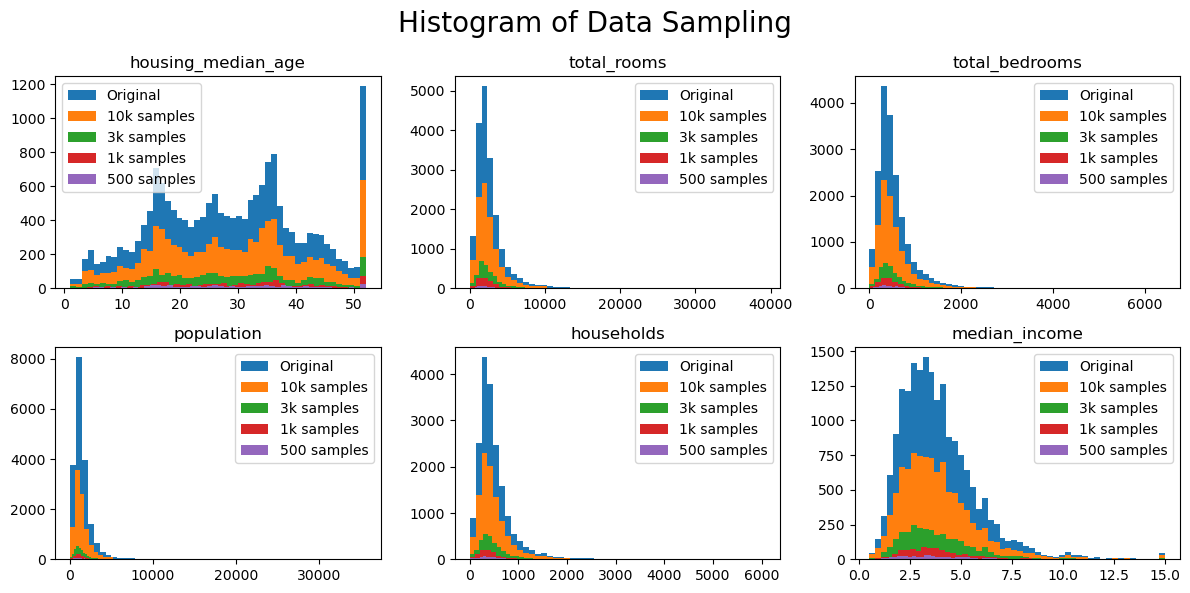

In [9]:
features = X.columns
n_features = len(features)
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()
for axs, feature in zip(axs,features):
    axs.hist(X_train[feature], bins=50, alpha=0.8, label='Original')
    axs.hist(X_train_10000[feature], bins=50, alpha=0.8, label='10k samples')
    axs.hist(X_train_3000[feature], bins=50, alpha=0.8, label='3k samples')
    axs.hist(X_train_1000[feature], bins=50, alpha=0.8, label='1k samples')
    axs.hist(X_train_500[feature], bins=50, alpha=0.8, label='500 samples')
    
    axs.set_title(feature, fontsize=12)
    axs.legend()

fig.suptitle('Histogram of Data Sampling', fontsize=20)
plt.tight_layout()
plt.show()


### MODEL TRAINING

In [10]:
model_orig = RandomForestRegressor(random_state=42)
model_10000 = RandomForestRegressor(random_state=42)
model_3000 = RandomForestRegressor(random_state=42)
model_1000 = RandomForestRegressor(random_state=42)
model_500 = RandomForestRegressor(random_state=42)

model_orig.fit(X_train, y_train)
model_10000.fit(X_train_10000, y_train_10000)
model_3000.fit(X_train_3000, y_train_3000)
model_1000.fit(X_train_1000, y_train_1000)
model_500.fit(X_train_500, y_train_500)

RandomForestRegressor(random_state=42)

### SHAPLEY IMPLEMENTATION

In [11]:
explainer_10000 = shap.Explainer(model_10000)
explainer_3000 = shap.Explainer(model_3000)
explainer_1000 = shap.Explainer(model_1000)
explainer_500 = shap.Explainer(model_500)

In [12]:
shap_val_10000 =  explainer_10000(X_test)
shap_val_3000 = explainer_3000(X_test)
shap_val_1000 = explainer_1000(X_test)
shap_val_500 =  explainer_500(X_test)

In [13]:
# Calculate and print the mean squared error (MSE)
mse_orig = mean_squared_error(y_test, model_orig.predict(X_test))
mse_10000 = mean_squared_error(y_test, model_10000.predict(X_test))
mse_3000 = mean_squared_error(y_test, model_3000.predict(X_test))
mse_1000 = mean_squared_error(y_test, model_1000.predict(X_test))
mse_500 = mean_squared_error(y_test, model_500.predict(X_test))

print(f'MSE Original: {mse_orig:.2f}')
print(f'MSE 10000 samples: {mse_10000:.2f}')
print(f'MSE 3000 samples: {mse_3000:.2f}')
print(f'MSE 1000 samples: {mse_1000:.2f}')
print(f'MSE 500 samples: {mse_500:.2f}')


MSE Original: 0.51
MSE 10000 samples: 0.53
MSE 3000 samples: 0.55
MSE 1000 samples: 0.59
MSE 500 samples: 0.63


In [14]:
n = 2

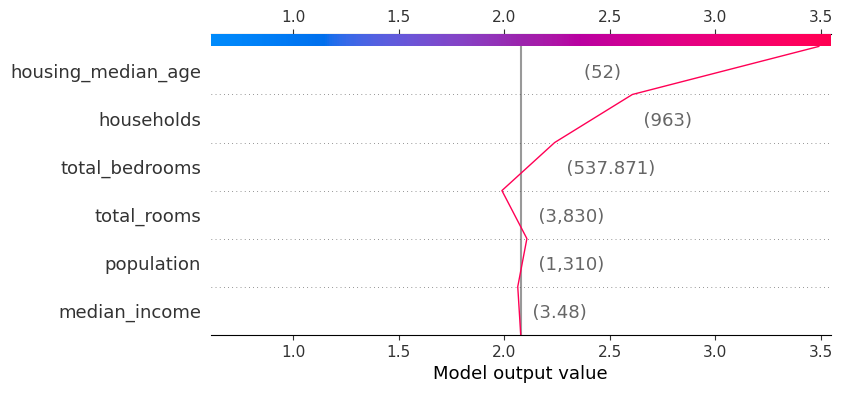

In [15]:
shap.decision_plot(explainer_10000.expected_value, shap_val_10000.values[n], X_test.iloc[n], link='identity', show=True)

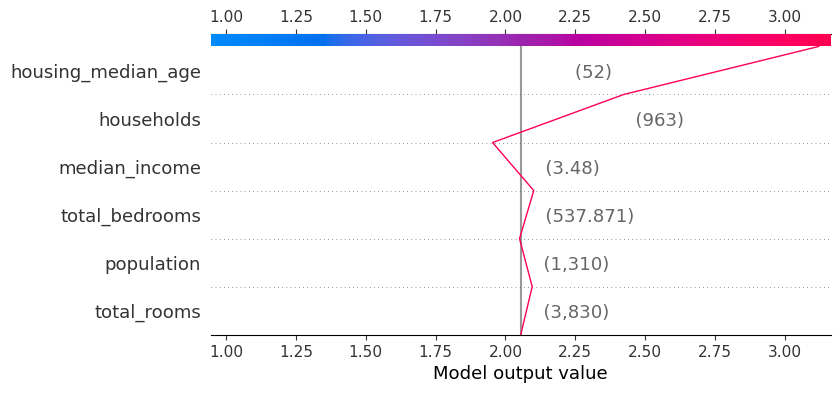

In [16]:
shap.decision_plot(explainer_3000.expected_value, shap_val_3000.values[n], X_test.iloc[n], link='identity', show=False)

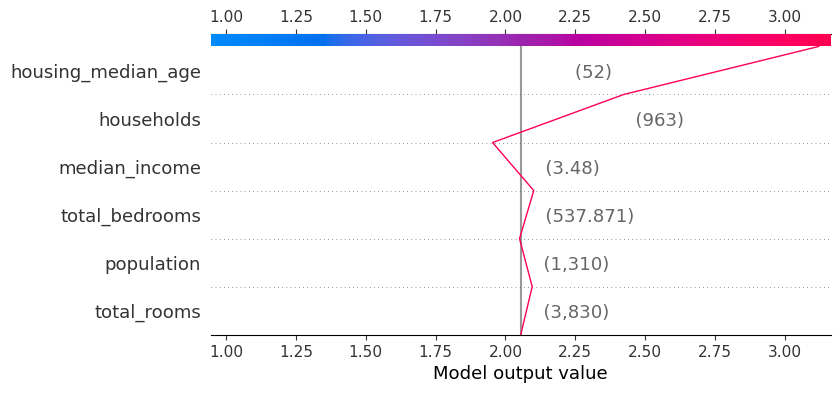

In [17]:
shap.decision_plot(explainer_3000.expected_value, shap_val_3000.values[n], X_test.iloc[n], link='identity', show=True)

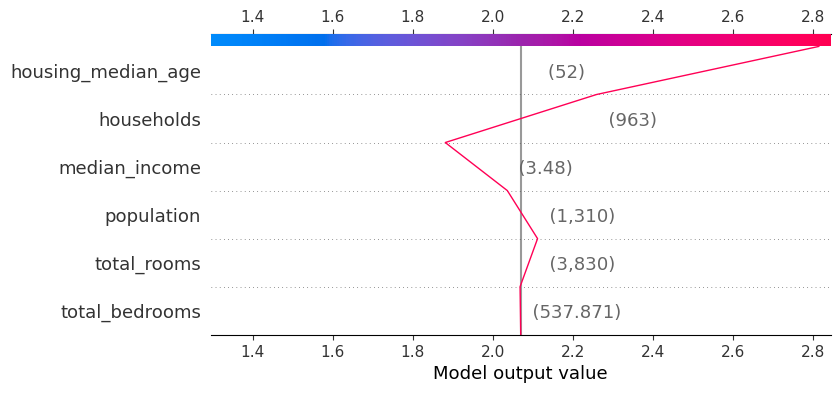

In [18]:
shap.decision_plot(explainer_1000.expected_value, shap_val_1000.values[n], X_test.iloc[n], link='identity', show=True)

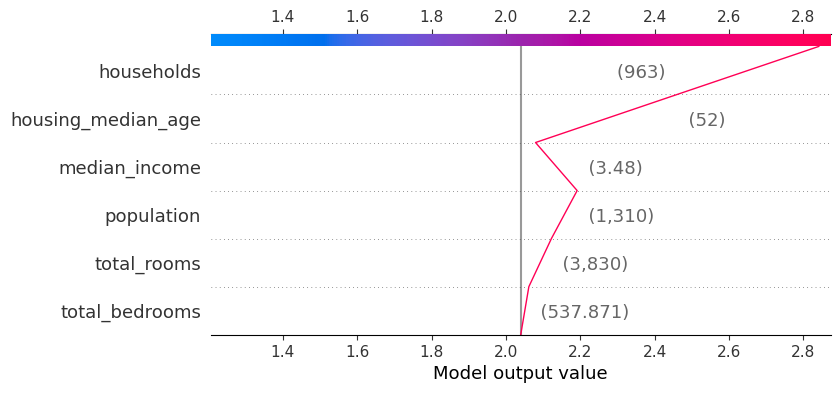

In [19]:
shap.decision_plot(explainer_500.expected_value, shap_val_500.values[n], X_test.iloc[n], link='identity', show=True)

In [20]:
shap_summary = pd.DataFrame(index = ['10k', '3k', '1k', 500],
                            columns=X_train.columns)

In [21]:
shap_summary.iloc[0] = np.abs(shap_val_10000.values).mean(axis=0)/np.sum(np.abs(shap_val_10000.values).mean(axis=0))*100
shap_summary.iloc[1] = np.abs(shap_val_3000.values).mean(axis=0)/np.sum(np.abs(shap_val_3000.values).mean(axis=0))*100
shap_summary.iloc[2] = np.abs(shap_val_1000.values).mean(axis=0)/np.sum(np.abs(shap_val_1000.values).mean(axis=0))*100
shap_summary.iloc[3] = np.abs(shap_val_500.values).mean(axis=0)/np.sum(np.abs(shap_val_500.values).mean(axis=0))*100

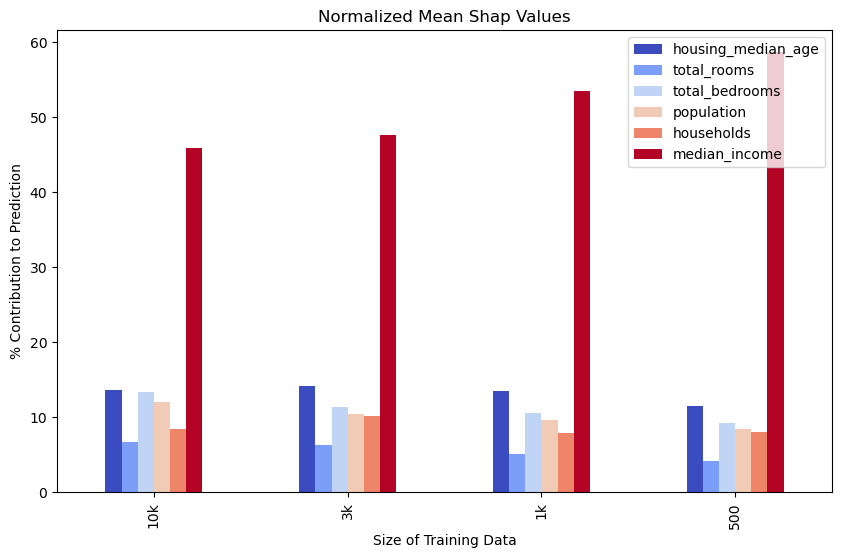

In [22]:
shap_summary.plot.bar(figsize=(10,6), cmap='coolwarm')
plt.ylabel('% Contribution to Prediction')
plt.xlabel('Size of Training Data')
plt.title('Normalized Mean Shap Values')
plt.show()

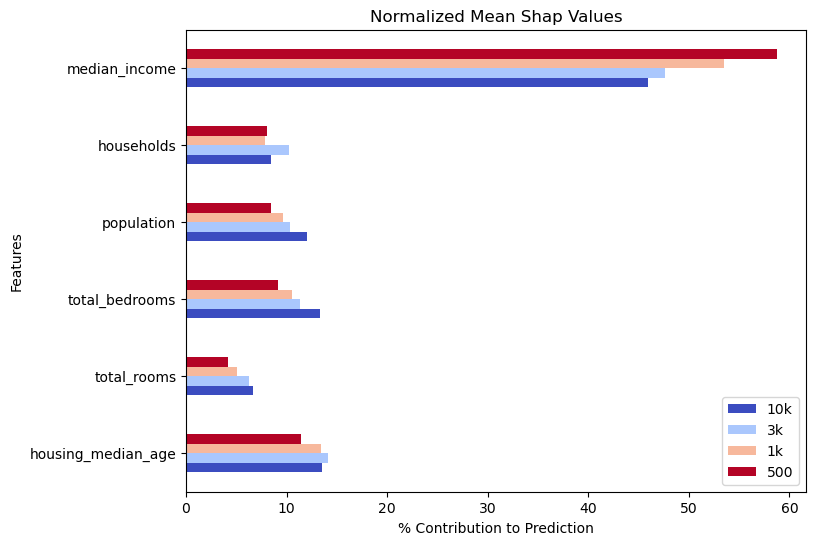

In [24]:
shap_summary.transpose().plot.barh(figsize=(8,6), cmap='coolwarm');
plt.ylabel('Features')
plt.xlabel('% Contribution to Prediction')
plt.title('Normalized Mean Shap Values')
plt.show()

### INSIGHTS

- Mean Squared Error Decreases as training data size sample decreases.
- The MSE for sampled data is still close to the MSE of the model trained with unsampled data. Specially until 3000 sample size.
- The RandomForest models trained on different sample sizes had different base predictions.
- The SHAP values vary for each model trained on different sample sizes.
- For a specific prediction, the SHAP value for some features can be negative for one model and positive for another.
- As sample size decreases the model's emphasis on a prominent top predictor increases.